In [13]:
import pandas as pd
import datetime
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
num = range(7)

In [15]:
final_data = pd.read_csv("final_data.csv")

In [16]:
final_data_list = {}

In [17]:
for i in num:
    final_data_test = final_data.copy(deep=True)
    j = i + 1
    final_data_test["lag"+str(j+0)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+0)
    final_data_test["lag"+str(j+1)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+1)
    final_data_test["lag"+str(j+2)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+2)
    final_data_test["lag"+str(j+3)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+3)
    final_data_test["lag"+str(j+4)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+4)
    final_data_test["lag"+str(j+5)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+5)
    final_data_test["lag"+str(j+6)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+0)
    final_data_test["lag"+str(j+1)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+1)
    final_data_test["lag"+str(j+2)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+2)
    final_data_test["lag"+str(j+3)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+3)
    final_data_test["lag"+str(j+4)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+4)
    final_data_test["lag"+str(j+5)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+5)
    final_data_test["lag"+str(j+6)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+0)
    final_data_test["lag"+str(j+1)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+1)
    final_data_test["lag"+str(j+2)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+2)
    final_data_test["lag"+str(j+3)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+3)
    final_data_test["lag"+str(j+4)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+4)
    final_data_test["lag"+str(j+5)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+5)
    final_data_test["lag"+str(j+6)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+0)
    final_data_test["lag"+str(j+1)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+1)
    final_data_test["lag"+str(j+2)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+2)
    final_data_test["lag"+str(j+3)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+3)
    final_data_test["lag"+str(j+4)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+4)
    final_data_test["lag"+str(j+5)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+5)
    final_data_test["lag"+str(j+6)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+6)
    
    
    final_data_test = final_data_test.dropna().copy(deep = True)
    
    final_data_test['Fully_reopen']        = final_data_test['Fully_reopen'].astype(object)
    final_data_test['Mask_Mandate']        = final_data_test['Mask_Mandate'].astype(object)
    final_data_test['Vaccination_or_test'] = final_data_test['Vaccination_or_test'].astype(object)
    final_data_test['State']               = final_data_test['State'].astype(object)
    final_data_test['Region']              = final_data_test['Region'].astype(object)
    final_data_test['Division']            = final_data_test['Division'].astype(object)
    
    final_data_test = final_data_test.drop(columns=['People_Fully_Vaccinated', 'tests_combined_total']).copy(deep = True)

    final_data_list["final_data_"+str(j)] = final_data_test
    
    

In [50]:
params_list = []

In [59]:
for i in final_data_list:
    
    # Set default parameters
    params = {
        # Parameters that we are going to tune.
        'max_depth':6,
        'min_child_weight': 1,
        'eta':.3,
        'subsample': 1,
        'colsample_bytree': 1,
        # Other parameters
        'objective':'reg:linear',
        'eval_metric': 'mae'
    }    
    
    # read in data and preprocessing
    data = final_data_list[i].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Case"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Case"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    """Tune max_depth & min_child_weight"""
    gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(0,10)
    for min_child_weight in range(0,8)]

    # Define initial best params and MAE
    min_mae = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
    #     print("CV with max_depth={}, min_child_weight={}".format(
    #                              max_depth,
    #                              min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=10
        )
        # Update best MAE
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (max_depth,min_child_weight)
    #print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

    params['max_depth'] = best_params[0]
    params['min_child_weight'] = best_params[1]    

    """Tune subsample & colsample"""
    gridsearch_params = [
        (subsample, colsample)
        for subsample in [i/10. for i in range(3,7)]
        for colsample in [i/10. for i in range(3,7)]
    ]    
    
    min_mae = float("Inf")
    best_params = None
    # We start by the largest values and go down to the smallest
    for subsample, colsample in reversed(gridsearch_params):
#         print("CV with subsample={}, colsample={}".format(
#                                  subsample,
#                                  colsample))
        # We update our parameters
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=10
        )
        # Update best score
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (subsample,colsample)
    params['subsample'] = best_params[0]
    params['colsample_bytree'] = best_params[1]     
    #print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))    
    
    """Tune ETA"""
    min_mae = float("Inf")
    best_params = None
    for eta in [.3, .2, .1, .05, .01, .005]:
        #print("CV with eta={}".format(eta))
        # We update our parameters
        params['eta'] = eta
        # Run and time CV
        cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=num_boost_round,
                seed=42,
                nfold=5,
                metrics=['mae'],
                early_stopping_rounds=10)
        # Update best score
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        #print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = eta
    #print("Best params: {}, MAE: {}".format(best_params, min_mae))
    params['eta'] = best_params
    
    params_list.append(params)
    

[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:34] WARNING: ../src/objective/regression_

In [63]:
params_list[7:14]

[{'max_depth': 7,
  'min_child_weight': 1,
  'eta': 0.05,
  'subsample': 0.6,
  'colsample_bytree': 0.5,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 6,
  'min_child_weight': 4,
  'eta': 0.1,
  'subsample': 0.6,
  'colsample_bytree': 0.5,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 7,
  'min_child_weight': 1,
  'eta': 0.1,
  'subsample': 0.6,
  'colsample_bytree': 0.6,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 8,
  'min_child_weight': 3,
  'eta': 0.005,
  'subsample': 0.6,
  'colsample_bytree': 0.6,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 5,
  'min_child_weight': 0,
  'eta': 0.05,
  'subsample': 0.6,
  'colsample_bytree': 0.5,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 7,
  'min_child_weight': 2,
  'eta': 0.05,
  'subsample': 0.6,
  'colsample_bytree': 0.5,
  'objective': 'reg:linear',
  'eval_metric': 'mae'},
 {'max_depth': 8,
  'min_child_weight': 0,
  'e

In [ ]:
p = params_list[7:14]

In [ ]:
model_list = []

In [ ]:
for i in range(len(7)):
    # read in data and preprocessing
    data = final_data_list["final_data_"+str(j)].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Case"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Case"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)    
    
    # fit model with best params
    model = xgb.train(
        params[i],
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10
    )
    
    model_list.append(model)

    

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [18]:
data = final_data_list["final_data_1"]
data = data.drop(["Date","State","state"], 1)
data.columns

Index(['Region', 'Division', 'Daily_Death', 'Daily_Case',
       'Above_Poverty_Level_Population', 'No_Health_Insurance_Population',
       'population', 'Median_Income', '65_Years_or_More_Population',
       '25_Years_or_More_Population', 'Population_Density',
       'Bachelors_Degree_or_Higher_Population', 'Fully_reopen', 'Mask_Mandate',
       'Vaccination_or_test', 'Ratio of people per hospital employee',
       'Ratio of people per hospital', 'gdp_2020', 'employed_population',
       'lag1c', 'lag2c', 'lag3c', 'lag4c', 'lag5c', 'lag6c', 'lag7c', 'lag1d',
       'lag2d', 'lag3d', 'lag4d', 'lag5d', 'lag6d', 'lag7d', 'lag1t', 'lag2t',
       'lag3t', 'lag4t', 'lag5t', 'lag6t', 'lag7t', 'lag1v', 'lag2v', 'lag3v',
       'lag4v', 'lag5v', 'lag6v', 'lag7v'],
      dtype='object')

In [19]:
data = pd.get_dummies(data)
data.columns

Index(['Daily_Death', 'Daily_Case', 'Above_Poverty_Level_Population',
       'No_Health_Insurance_Population', 'population', 'Median_Income',
       '65_Years_or_More_Population', '25_Years_or_More_Population',
       'Population_Density', 'Bachelors_Degree_or_Higher_Population',
       'Ratio of people per hospital employee', 'Ratio of people per hospital',
       'gdp_2020', 'employed_population', 'lag1c', 'lag2c', 'lag3c', 'lag4c',
       'lag5c', 'lag6c', 'lag7c', 'lag1d', 'lag2d', 'lag3d', 'lag4d', 'lag5d',
       'lag6d', 'lag7d', 'lag1t', 'lag2t', 'lag3t', 'lag4t', 'lag5t', 'lag6t',
       'lag7t', 'lag1v', 'lag2v', 'lag3v', 'lag4v', 'lag5v', 'lag6v', 'lag7v',
       'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West',
       'Division_East North Central', 'Division_East South Central',
       'Division_Middle Atlantic', 'Division_Mountain', 'Division_New England',
       'Division_Pacific', 'Division_South Atlantic',
       'Division_West North Central', 'Divisi

In [20]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [21]:
len(train)

10980

In [22]:
y_train = train["Daily_Case"]
X_train = train.drop(["Daily_Case","Daily_Death"],1)
y_test = test["Daily_Case"]
X_test = test.drop(["Daily_Case","Daily_Death"],1)

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [24]:
"""Calculate Baseline MAE"""
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 1310.44


In [25]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}


In [26]:
params['eval_metric'] = "mae"

In [40]:
params

{'max_depth': 7,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 0.3,
 'colsample_bytree': 0.3,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

In [27]:
num_boost_round = 999

In [28]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[01:18:44] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:955.88464
[1]	Test-mae:705.71301
[2]	Test-mae:541.59699
[3]	Test-mae:434.90891
[4]	Test-mae:371.71729
[5]	Test-mae:338.40988
[6]	Test-mae:320.74252
[7]	Test-mae:311.51126
[8]	Test-mae:306.49136
[9]	Test-mae:304.10834
[10]	Test-mae:303.10465
[11]	Test-mae:302.65521
[12]	Test-mae:302.80011
[13]	Test-mae:301.58881
[14]	Test-mae:301.30081
[15]	Test-mae:300.93060
[16]	Test-mae:299.99655
[17]	Test-mae:299.63260
[18]	Test-mae:299.54221
[19]	Test-mae:298.61871
[20]	Test-mae:299.04767
[21]	Test-mae:299.11975
[22]	Test-mae:297.68329
[23]	Test-mae:297.60355
[24]	Test-mae:297.31775
[25]	Test-mae:297.08395
[26]	Test-mae:296.59067
[27]	Test-mae:297.38946
[28]	Test-mae:297.38531
[29]	Test-mae:296.47754
[30]	Test-mae:296.42194
[31]	Test-mae:296.27286
[32]	Test-mae:296.31635
[33]	Test-mae:295.53937
[34]	Test-mae:295.35709
[35]	Test-mae:295.52484
[36]	Test-mae:295.34424
[37

In [41]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,9)
    for min_child_weight in range(0,2)
]

In [44]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}".format(
#                              max_depth,
#                              min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

[01:56:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:46] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:46] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:46] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:46] WARNING: ../src/objective/regression_

In [36]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(3,7)]
    for colsample in [i/10. for i in range(3,7)]
]


In [37]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=0.6, colsample=0.6
[01:39:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 328.0194822 for 31 rounds
CV with subsample=0.6, colsample=0.5
[01:39:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:14] WARNING: ../src/objective/regression_obj.cu:170: re

In [49]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=500,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

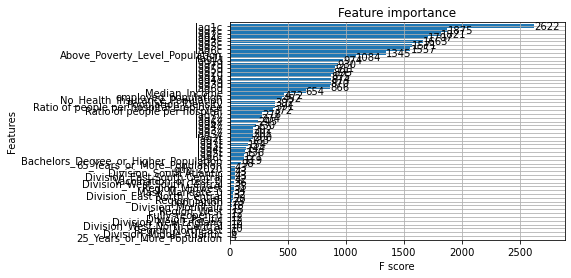

In [30]:
_ = plot_importance(reg, height=0.9)

In [31]:
test["Case_Prediction"] = reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


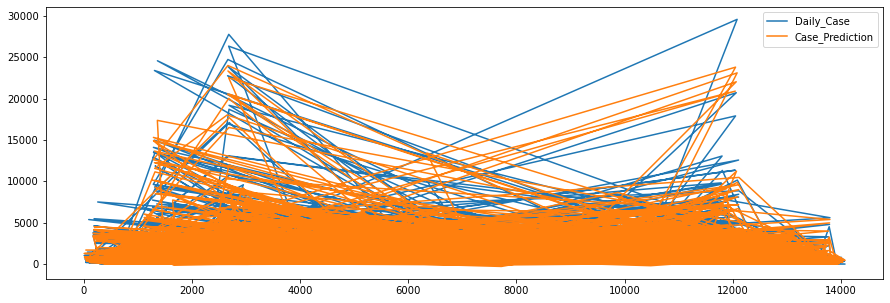

In [32]:
_ = test[['Daily_Case','Case_Prediction']].plot(figsize=(15, 5))

In [33]:
def RMSLE(y_true, y_pred):
    result = np.sqrt(1/len(y_true)*np.sum((np.log(y_pred+1)-np.log(y_true+1))**2))
    return(result)

In [34]:
RMSLE(test["Daily_Case"], reg.predict(X_test))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


1.1093504394845184

In [ ]:
n_es = [1,2,3,4]

In [38]:
?xgb.XGBRegressor

Init signature: xgb.XGBRegressor(*, objective='reg:squarederror', **kwargs)
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: string
        Specify which tree method to use.  Default to auto.  If this parameter
        is set to default, XGBoost will choose the most conservative option
        available.  It's recomme

In [36]:
test[["Daily_Case", "Case_Prediction"]]

,Daily_Case,Case_Prediction
11338,232,135.599655
12407,0,218.724869
1617,2280,1556.576660
3749,958,825.369934
607,570,554.344666
1779,38,79.132935
5948,112,87.334099
9022,2758,2921.814453
5268,157,184.558273
188,4623,4127.174316
